In [70]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms.functional as F
from pycocotools.coco import COCO


In [102]:
class ImageSegmenter:
    def __init__(self, model_path, device=None):
        '''Initializes the image segmenter with the model and device'''
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.load_model(model_path)
        self.confidence_threshold = input("Enter confidence threshold (default 0.5): ") or 0.5
        self.confidence_threshold = float(self.confidence_threshold)

    def load_model(self, model_path):
        '''Loads MaskRCNN model with the custom configuration'''
        print("Loading model...")
        num_classes = 2  # Background + 1 object class
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

        # Replace the box predictor
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

        # Replace the mask predictor
        in_channels_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels_mask, 256, num_classes)

        # Load the weights
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model.to(self.device)
        model.eval()
        model.roi_heads.detections_per_img = 10000  # Remove the limit of objects
        print("✅ Model loaded successfully!")
        return model

    def load_image(self, image_path):
        '''Loads an image and converts it to a tensor'''
        print("Loading image...")
        image = Image.open(image_path).convert("RGB")
        image_tensor = F.to_tensor(image).to(self.device)  # Convert to tensor and move to device
        print("✅ Image loaded successfully!")
        return image, image_tensor

    def run_inference(self, image_tensor):
        '''Run inference on the model'''
        print("Running inference...")
        with torch.no_grad():
            prediction = self.model([image_tensor])

        pred_boxes = prediction[0]["boxes"].cpu().numpy()
        pred_masks = prediction[0]["masks"].cpu().numpy()
        pred_scores = prediction[0]["scores"].cpu().numpy()
        keep = pred_scores > self.confidence_threshold
        filtered_boxes = pred_boxes[keep]
        filtered_masks = pred_masks[keep]
        filtered_scores = pred_scores[keep]
        binary_masks = (filtered_masks > 0.5).astype(np.uint8)
        print(f"✅ {len(filtered_boxes)} objects detected for {self.confidence_threshold} threshold!")
        return filtered_boxes, binary_masks, filtered_scores


    def visualize_predictions(self, image, boxes, masks, scores):
        '''Visualizes predictions with bounding boxes and masks'''
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(image)

        # Apply threshold for the scores
        keep = scores > self.confidence_threshold
        boxes = boxes[keep]
        masks = masks[keep]
        scores = scores[keep]

        # Draw bounding boxes and masks
        for box, mask, score in zip(boxes, masks, scores):
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, f"{score:.2f}", color="red", fontsize=12, backgroundcolor="white")

            # Overlay masks
            mask = mask[0]  # Mask is (1, H, W), take the first channel
            color = np.random.rand(3)  # Random color for mask
            image_mask = np.zeros_like(image, dtype=np.uint8)
            image_mask[mask > 0.0] = (color * 255).astype(np.uint8)

            # Blend mask with original image
            image = np.array(image)
            image = cv2.addWeighted(image, 1, image_mask, 0.85, 0)

        ax.imshow(image)
        plt.axis("off")
        plt.show()

    def return_mask(self, image, masks):
        '''Generates and returns a combined mask'''
        combined_mask = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)

        for mask in masks:
            combined_mask = np.maximum(combined_mask, mask[0])  # Combine all masks into one (maximum mask value)

        plt.imshow(combined_mask)
        plt.axis("off")
        plt.title("Combined Mask")
        plt.show()

        return combined_mask

    def return_segmented_image(self, image, combined_mask):
        '''Generates a segmented image using the combined mask'''
        segmented_image = np.array(image)
        combined_mask_rgb = np.stack([combined_mask] * 3, axis=-1)
        segmented_image = segmented_image * combined_mask_rgb
        segmented_image = segmented_image.astype(np.uint8)
        segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10))
        plt.imshow(segmented_image)
        plt.axis("off")
        plt.title("Segmented Residue")
        plt.show()

        return segmented_image

    def return_amount_of_residue(self, combined_mask):
        '''Calculates the amount of residue detected in the image as a percentage of the total area'''
        total_pixels = combined_mask.shape[0] * combined_mask.shape[1]
        occupied_pixels = np.sum(combined_mask > 0)
        occupied_percentage = (occupied_pixels / total_pixels) * 100
        print(f"Residue Persentage: {occupied_percentage:.2f}%")
        return occupied_percentage

Initialize...

Loading model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-102-a86fe8f452cd>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

✅ Model loaded successfully!
Enter confidence threshold (default 0.5): 0.0
Loading image...
✅ Image loaded successfully!
Running inference...
✅ 217 objects detected for 0.0 threshold!


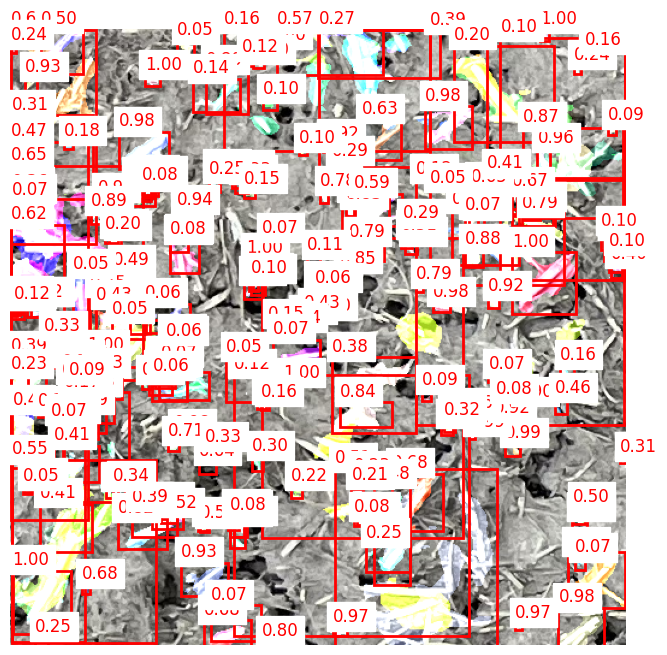

In [ ]:
image_path = "data/raw/test/IMG_0629_part05.jpg"
model_path= r"/content/residue_segmenter_mask_rcnn.pth"
segmenter = ImageSegmenter(model_path)
image, image_tensor = segmenter.load_image(image_path)
boxes, masks, scores = segmenter.run_inference(image_tensor)
segmenter.visualize_predictions(image, boxes, masks, scores)

Visualize masks, predictions, and the segmented image...

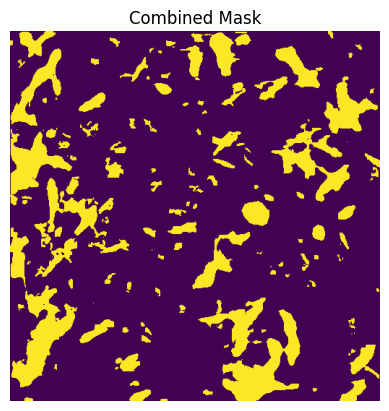

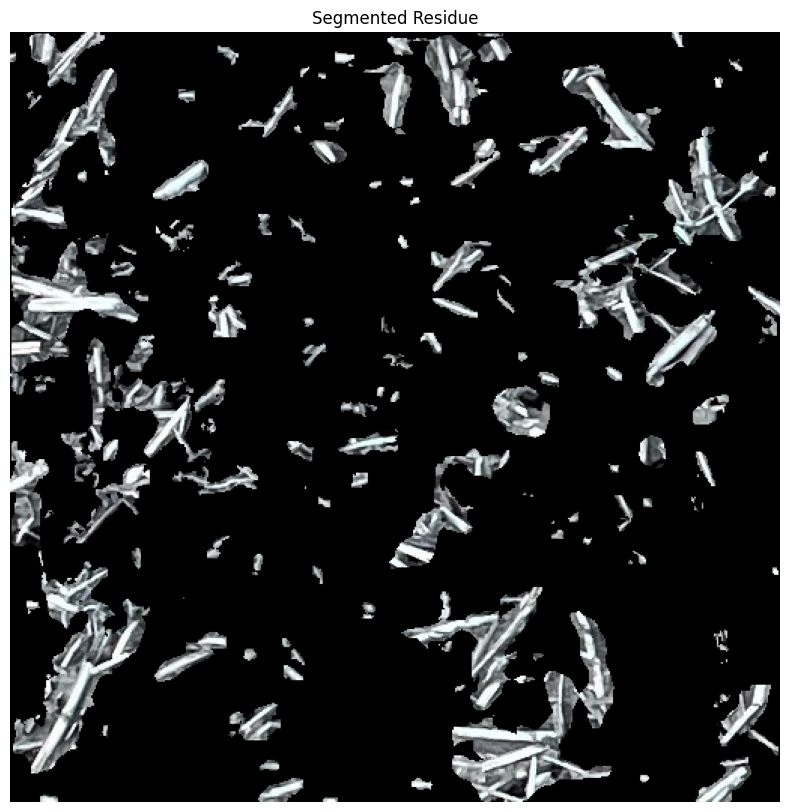

In [104]:
# Generate the combined mask
combined_mask = segmenter.return_mask(image, masks)

# Create a segmented image
segmented_image = segmenter.return_segmented_image(image, combined_mask)

Calculating the amount of residue...

In [105]:
# Calculate and print the percentage of residue
segmenter.return_amount_of_residue(combined_mask)

Residue Persentage: 18.75%


18.749618530273438